In [1]:
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from Cleaning import GetCleanedData
import pandas as pd
import matplotlib.pyplot as plt

# Chemin du fichier TAR
tar_path = '../corenlp_plot_summaries.tar'

# Fonction pour extraire le texte nettoyé de chaque fichier XML
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        # Parcourir chaque token dans le XML (ajustez si la structure XML diffère)
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            # Garder uniquement les lemmes de certains types de mots
            if pos in {'NN', 'VB', 'JJ'}:  # Noms, verbes, adjectifs
                filtered_words.append(lemma)
                
        return ' '.join(filtered_words)

# Liste pour stocker tous les documents traités
documents = []
ids = []

# Ouverture et traitement du fichier TAR
with tarfile.open(tar_path, 'r') as tar:
    # Parcourir chaque fichier dans le fichier TAR
    for member in tar.getmembers():
        # Vérifier si c'est un fichier XML compressé (.xml.gz)
        if member.name.endswith('.xml.gz'):
            # Extraire le fichier .xml.gz dans un fichier temporaire
            with tar.extractfile(member) as xml_gz_file:
                # Analyser le fichier XML pour obtenir le texte nettoyé
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

In [2]:
# Vectorisation avec CountVectorizer pour LDA
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(documents)
# Application de LDA
lda = LatentDirichletAllocation(n_components=6)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=6)

In [3]:
# Transformation des documents en probabilités de thème
doc_topic_dist = lda.transform(doc_term_matrix)

# Pour chaque document, trouver les 3 thèmes les plus présents avec leur proportion
top_themes_per_document = []
for i, doc in enumerate(doc_topic_dist):
    # Obtenir les indices des 3 thèmes les plus probables:
    top_indices = doc.argsort()[-3:][::-1]
    # Obtenir les proportions pour ces thèmes:
    top_proportions = doc[top_indices]

    # Ajouter les informations dans une structure de données par film
    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],  # Identifiant du film
        "Thème 1": top_indices[0],
        "Prop Thème 1": top_proportions[0],
        "Thème 2": top_indices[1],
        "Prop Thème 2": top_proportions[1],
        "Thème 3": top_indices[2],
        "Prop Thème 3": top_proportions[2]
    })

# Convertir en DataFrame pour une meilleure visualisation et merge avec le dataframe contenant les autres infos 
df_top_themes = pd.DataFrame(top_themes_per_document)
df1, df2,df3 = GetCleanedData()
df1['Wikipedia movie ID'] = df1['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df1, df_top_themes, on='Wikipedia movie ID', how='inner')
merged_df.head()

C:\Users\romai\OneDrive\EPFL\MA1\Applied_Data_Analysis\ada-2024-project-4bigbrains\Cleaning.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_revenue_clean['Movie release date'] = df_date_revenue_clean['Movie release date'].apply(format_date)
C:\Users\romai\OneDrive\EPFL\MA1\Applied_Data_Analysis\ada-2024-project-4bigbrains\Cleaning.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_clean['Movie release date'] = df_date_clean['Movie release date'].apply(format_date)
C:\Users\romai\OneDr

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Thème 1,Prop Thème 1,Thème 2,Prop Thème 2,Thème 3,Prop Thème 3
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",5,0.604267,2,0.189675,1,0.122634
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",1,0.373651,0,0.214867,4,0.176493
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],Germany,[Drama],0,0.885036,1,0.107584,4,0.001849
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],South Africa,"[Family Film, Fantasy, Adventure, World cinema]",1,0.632866,3,0.351476,2,0.003921
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],United States of America,"[Romantic comedy, Ensemble Film, Comedy-drama,...",0,0.979556,2,0.004106,4,0.004096


In [4]:
top_terms = []
terms = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    top_terms.append([terms[i] for i in topic.argsort()[-10:]])

max_prop_movies = merged_df.loc[merged_df.groupby('Thème 1')['Prop Thème 1'].idxmax()]
max_prop_movies.head()


for index, row in max_prop_movies.iterrows():
    theme_id = row['Thème 1']
    print(f"Topic {theme_id} with top terms: {top_terms[theme_id]}")
    print(f"Top film for Topic {theme_id}: ID = {row['Wikipedia movie ID']}, Title = {row['Movie name']}\n")

Topic 0 with top terms: ['wife', 'day', 'son', 'time', 'home', 'life', 'family', 'mother', 'love', 'father']
Top film for Topic 0: ID = 26672550, Title = The Pregnancy Pact

Topic 1 with top terms: ['dog', 'door', 'time', 'head', 'home', 'body', 'night', 'room', 'man', 'house']
Top film for Topic 1: ID = 6030859, Title = The House on Skull Mountain

Topic 2 with top terms: ['kill', 'help', 'group', 'time', 'fight', 'car', 'game', 'town', 'gang', 'team']
Top film for Topic 2: ID = 1779335, Title = Biker Boyz

Topic 3 with top terms: ['family', 'father', 'love', 'son', 'war', 'life', 'young', 'story', 'village', 'film']
Top film for Topic 3: ID = 25652572, Title = Mulan

Topic 4 with top terms: ['kill', 'case', 'car', 'death', 'prison', 'wife', 'murder', 'man', 'money', 'police']
Top film for Topic 4: ID = 43566, Title = Heat

Topic 5 with top terms: ['escape', 'plane', 'island', 'mission', 'world', 'attack', 'group', 'time', 'crew', 'ship']
Top film for Topic 5: ID = 8641297, Title = Ic

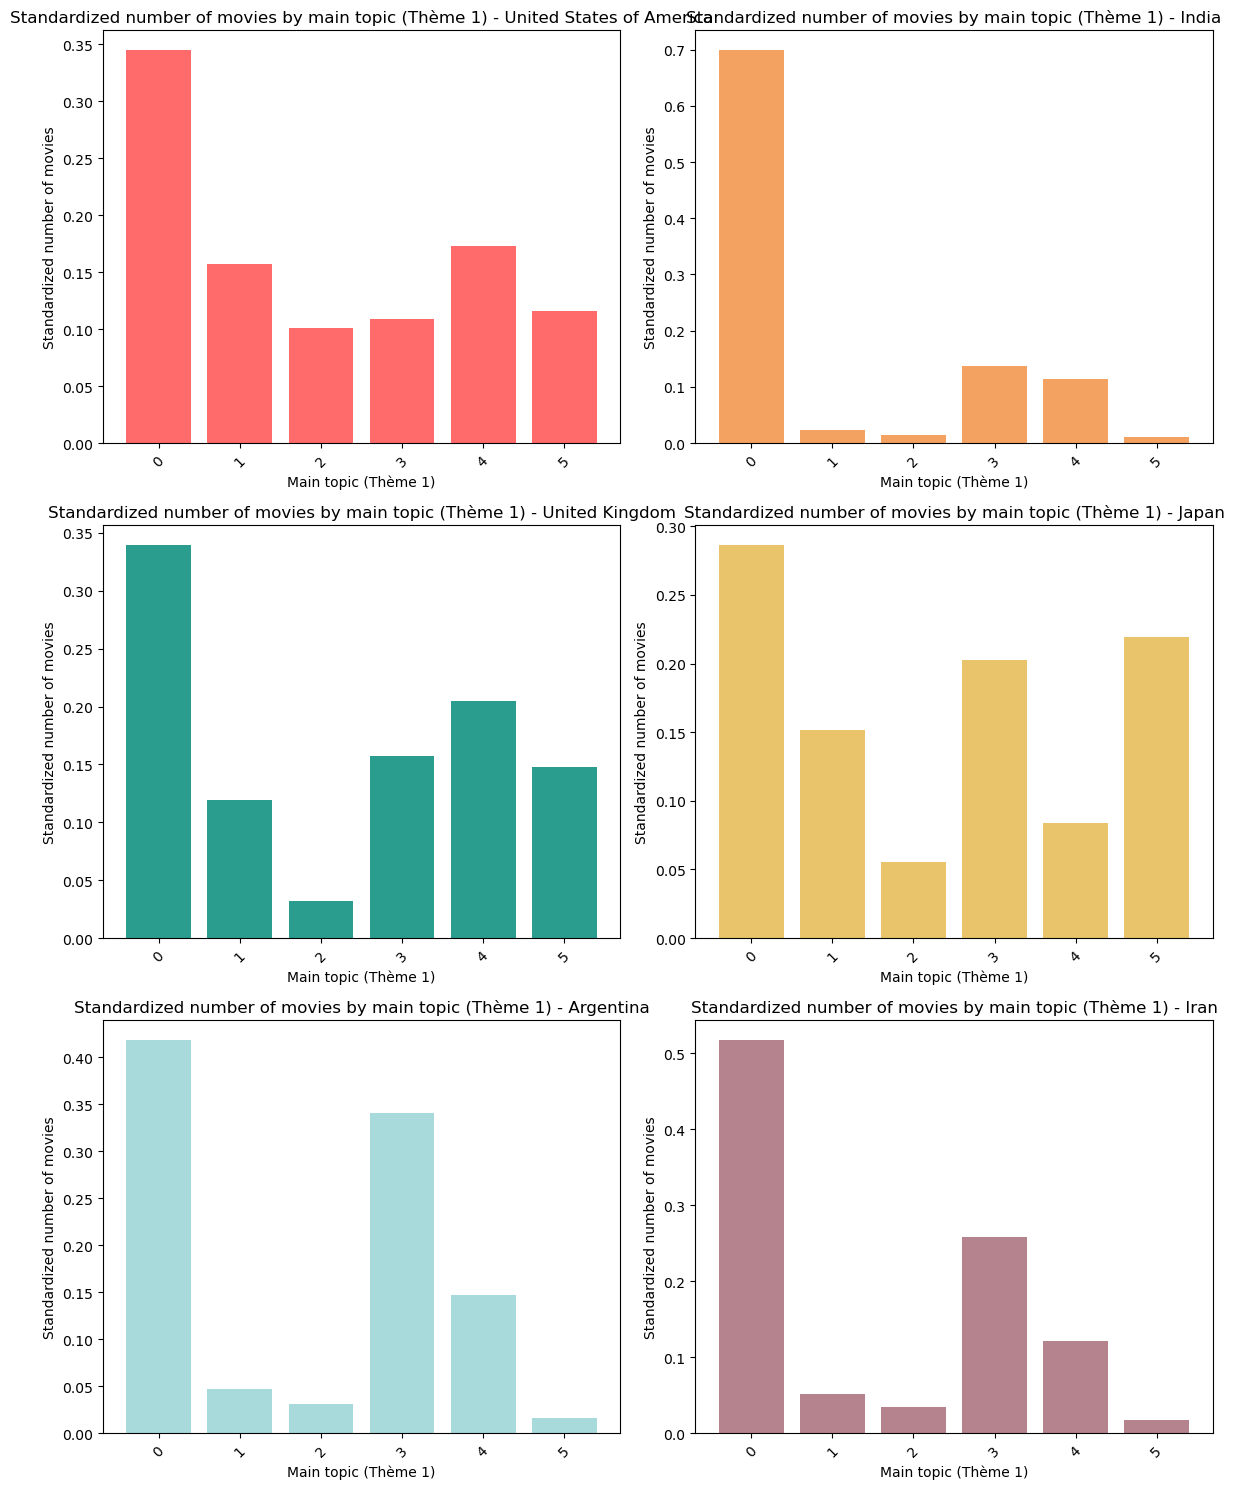

In [5]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']
colors = ['#FF6B6B', '#F4A261', '#2A9D8F', '#E9C46A', '#A8DADC', '#B5838D']

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    # Filter movies by country
    movies = merged_df[merged_df['Movie country'] == country]
    
    # Count the main themes (Thème 1) and standardize the counts
    theme_counts = movies['Thème 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()
    
    # Plot as a bar chart
    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values, color=colors[idx])
    axes[idx].set_title(f"Standardized number of movies by main topic (Thème 1) - {country}")
    axes[idx].set_xlabel("Main topic (Thème 1)")
    axes[idx].set_ylabel("Standardized number of movies")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index, rotation=45)

plt.tight_layout()
plt.show()